In this assignment students need to predict whether a person makes over 
50K per year or not from classic adult dataset using XGBoost. The 
description of the dataset is as follows: 
 
Data Set Information: 
Extraction was done by Barry Becker from the 1994 Census 
database. A set of reasonably clean records was extracted using the following conditions: 
((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) 
...
 


In [90]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [91]:
# Importing our train_set datasets
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None) 
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None) 

In [92]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [93]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [94]:
#Adding columns header for our data.
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',  
'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 
'capital_loss', 'hours_per_week', 'native_country', 'wage_class'] 

In [95]:
#Applying the change to both dataframes
train_set.columns = col_labels
test_set.columns = col_labels

DATA ANALYSIS

In [96]:
#Checking if Pandas has identified any of the missing values.
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [97]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  wage_class      16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [98]:
train_set.replace(' ?', np.nan).dropna().shape  # Our missing rows in train_set

(30162, 15)

In [99]:
test_set.replace(' ?', np.nan).dropna().shape # Our missing rows in test_set

(15060, 15)

In [100]:
train_nomissing_values = train_set.replace(' ?', np.nan).dropna()
test_nomissing_values = test_set.replace(' ?', np.nan).dropna()

In [101]:
#Now let target income thresholds for test_set and check if that will affect train_set features
test_nomissing_values['wage_class'] = test_nomissing_values.wage_class.replace({' <=50K.': ' <=50K', ' >50K.': ' >50K' })

In [102]:
#Checking the unique values from each set, we can see if they now match.
test_nomissing_values.wage_class.unique()   #Removing the (.)

array([' <=50K', ' >50K'], dtype=object)

In [103]:
train_nomissing_values.wage_class.unique() #Removing the (.)

array([' <=50K', ' >50K'], dtype=object)

DATA PREPROCESSING CATEGORICAL FEATURES

In [104]:
#Let apply Ordinal Encoding to Categoricals instead of One-Hot-Encoding by stacking them vertically
mixed_set = pd.concat([train_nomissing_values, test_nomissing_values], axis = 0) 

In [105]:
mixed_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education_num   45222 non-null  int64 
 5   marital_status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital_gain    45222 non-null  int64 
 11  capital_loss    45222 non-null  int64 
 12  hours_per_week  45222 non-null  int64 
 13  native_country  45222 non-null  object
 14  wage_class      45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [106]:
"""RENAMING train_set FEATURES"""
# Lets rename our train_set columns names with proper names 
mixed_set.rename(columns={'education_num':'educationalNo','capital_gain': 'gain', 'capital_loss': 'loss', 'native_country': 'country','hours_per_week': 'hoursPerWeek','marital_status': 'marital', 'wage_class':'income'}, inplace=True)
mixed_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educationalNo', 'marital',
       'occupation', 'relationship', 'race', 'sex', 'gain', 'loss',
       'hoursPerWeek', 'country', 'income'],
      dtype='object')

In [107]:
#Let encode the feature which are not numerical.
for feature in mixed_set.columns:
    if mixed_set[feature].dtype == 'object': #its only applies to columns to with categorical strings
        mixed_set[feature] = pd.Categorical(mixed_set[feature]).codes # Replace strings with an integer


In [108]:
mixed_set.info() # Encoding Features info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            45222 non-null  int64
 1   workclass      45222 non-null  int8 
 2   fnlwgt         45222 non-null  int64
 3   education      45222 non-null  int8 
 4   educationalNo  45222 non-null  int64
 5   marital        45222 non-null  int8 
 6   occupation     45222 non-null  int8 
 7   relationship   45222 non-null  int8 
 8   race           45222 non-null  int8 
 9   sex            45222 non-null  int8 
 10  gain           45222 non-null  int64
 11  loss           45222 non-null  int64
 12  hoursPerWeek   45222 non-null  int64
 13  country        45222 non-null  int8 
 14  income         45222 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

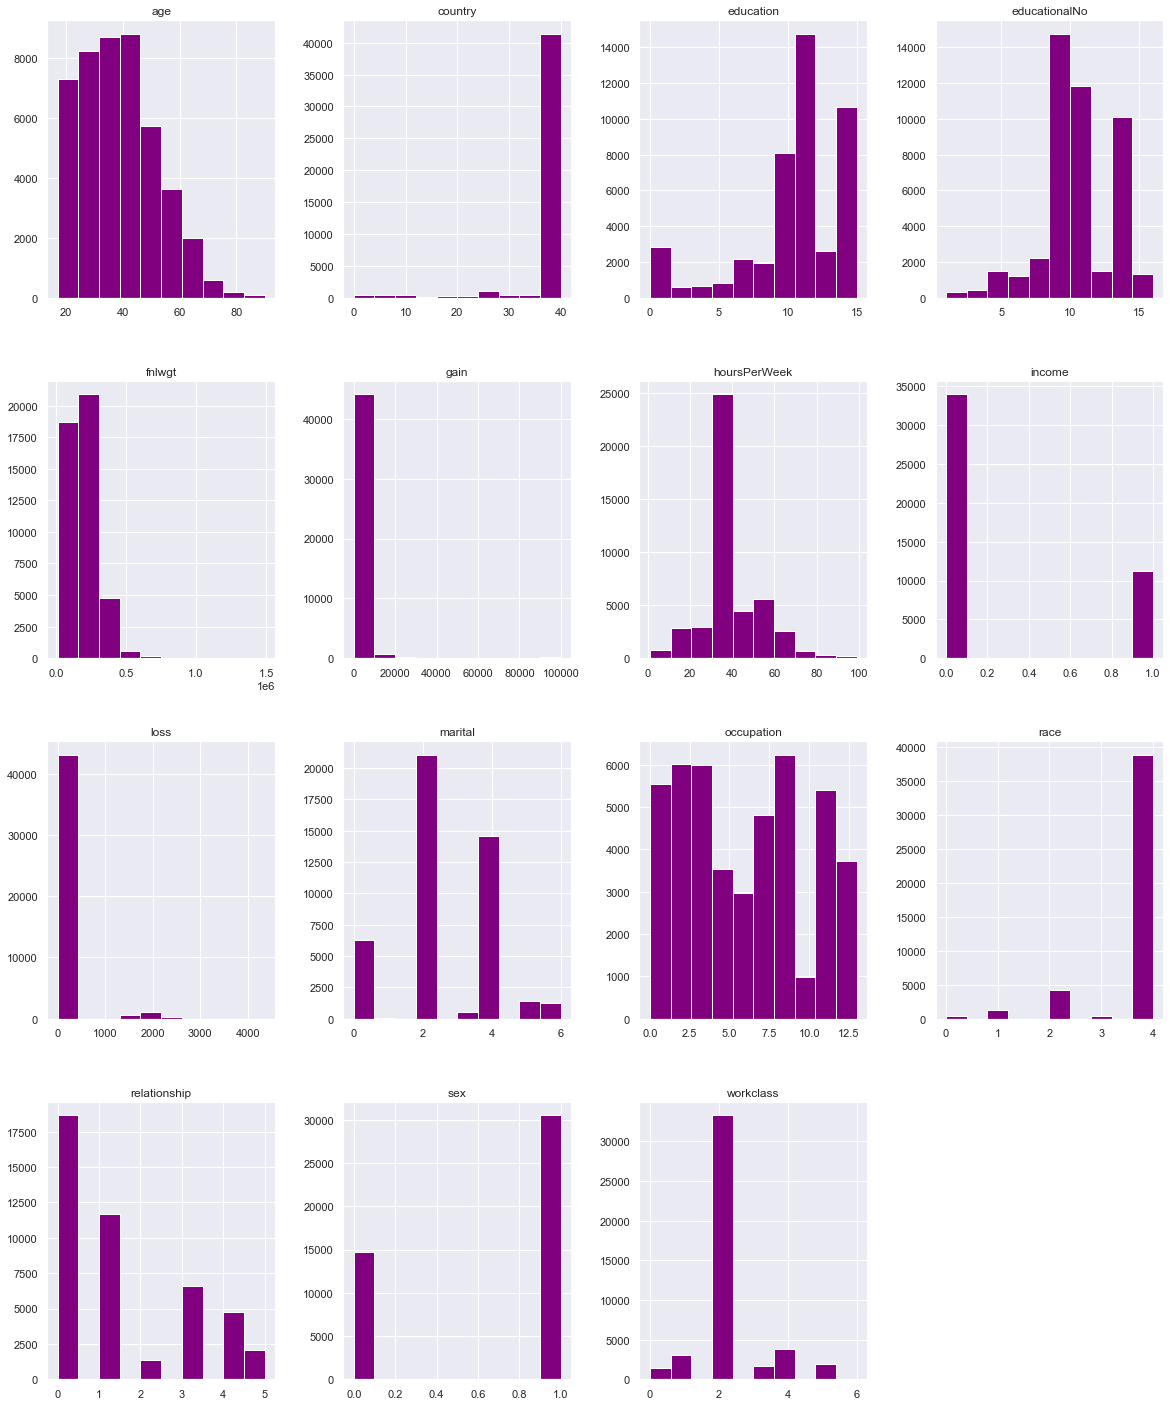

In [139]:
mixed_set.hist(figsize=(20,25), color= 'purple')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

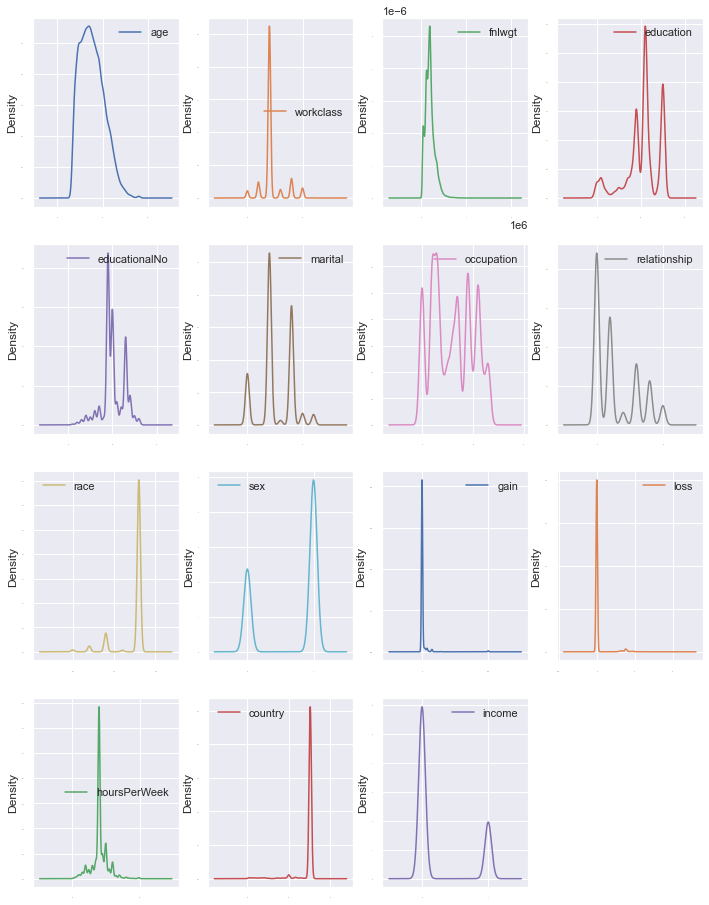

In [133]:
# Density Plots
mixed_set.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(12,16))
plt.show()

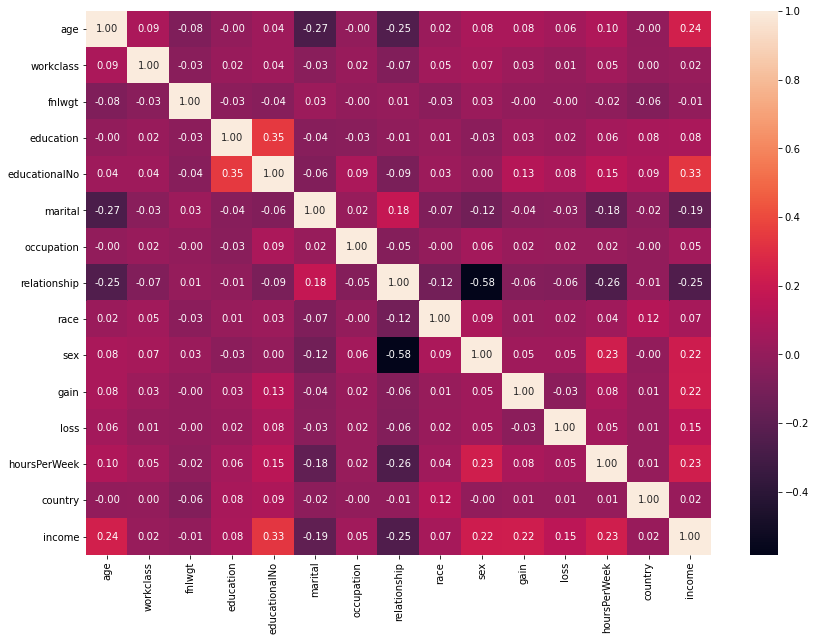

In [111]:
#Correlation using heatmap
plt.figure(figsize=(14,10))
sns.heatmap(mixed_set.corr(),annot=True,fmt='.2f')
plt.show()

FEATURES SELECTION AND PERFORMANCE EVALUATION - SPLITTING THE DATA

In [112]:
"""SPlitting features encoded back into their original train/test sizes"""
upto_last_train = mixed_set[:test_nomissing_values.shape[0]] 
past_last_test = mixed_set[train_nomissing_values.shape[0]:] 

Initial Model Setup & Grid Search

In [113]:
#Return item and drop from frame.Raise KeyError if not found.
y_train = upto_last_train.pop('income') 
y_test = past_last_test.pop('income')

In [114]:
#Let import some needfull libraries 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [115]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                            scoring= 'accuracy', cv = 5, n_jobs = -1)

In [116]:
#Now let's run our grid search with 5-fold cross-validation and see which parameters perform the best.
optimized_GBM.fit(upto_last_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimat...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=0, subsample=0.8, tree_met

In [117]:
# Checking grid scores and return to the best trainer
best_estimator = optimized_GBM.best_estimator_
best_estimator 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
#Output the accuracy of the optimal trainer
optimized_GBM.best_score_

0.8632802124833997

NOTE: The first hyper parameter perform best and we already notice good accuracy in our cross-validation.

In [119]:
"""Let try optimized some other hyperparamaters to increase our model the accuracy.
By subsampling along with lowering the learning rate."""

cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed': 0, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                            scoring= 'accuracy', cv= 5, n_jobs= -1)
optimized_GBM.fit(upto_last_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=0, subsample=None, tree_me

In [120]:
optimized_GBM.best_score_  # Checking the best scores however it does't look below like we can improve it.

0.8636122177954848

In [121]:
"""Fortunaly we can use XGBoost's API built-in cv testing early to improved our model.
Based on the CV testing performed earlier, we want to utilize the following parameters:

   - Learning_rate (eta) = 0.1
   - Subsample, colsample_bytree = 0.8
   - Max_depth = 3
   - Min_child_weight = 1

Now let make our XGBoost more efficient
"""

xgb_dmat = xgb.DMatrix(upto_last_train, y_train)

In [122]:
new_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1}
cv_xgb = xgb.cv(params= new_params, dtrain= xgb_dmat, num_boost_round=3000, nfold=5,
               metrics= ['error'], # to avoid unecessary issues
               early_stopping_rounds=100) # early stopp to minimizes errors

In [123]:
cv_xgb.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
320,0.114675,0.001399,0.134528,0.006051
321,0.114575,0.001201,0.134794,0.005917
322,0.114608,0.001152,0.134595,0.005799
323,0.114592,0.001123,0.134462,0.005712
324,0.114559,0.001125,0.134064,0.005892


Now our CV test error iterations is 11,4559% or 88,5441% accuracy🚀 which shows our best settings

In [124]:
# Creating XGBoost object model.
new_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight':1}
final_gb = xgb.train(new_params, xgb_dmat, num_boost_round=324)

In [125]:
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_context("poster")
sns.set(font_scale = 1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

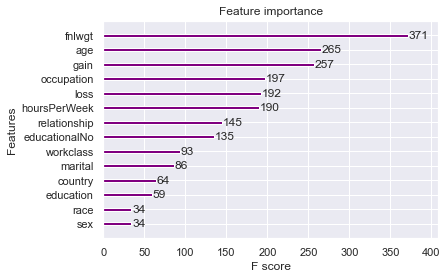

In [126]:
xgb.plot_importance(final_gb,  color='purple')

In [127]:
# Let build a chart of feature importances using the get_fscore method
import_dic = final_gb.get_fscore()
import_dic

{'relationship': 145,
 'gain': 257,
 'loss': 192,
 'age': 265,
 'educationalNo': 135,
 'fnlwgt': 371,
 'hoursPerWeek': 190,
 'education': 59,
 'marital': 86,
 'occupation': 197,
 'sex': 34,
 'workclass': 93,
 'race': 34,
 'country': 64}

<AxesSubplot:ylabel='Feature'>

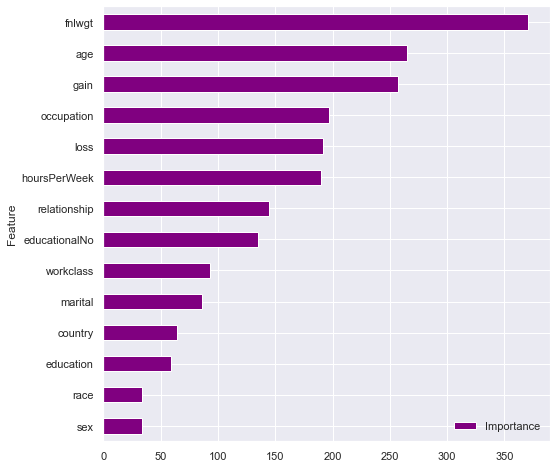

In [128]:
# Now let make a plot
import_frame = pd.DataFrame({'Importance': list(import_dic.values()),'Feature': list(import_dic.keys())})
import_frame.sort_values(by = 'Importance', inplace = True)
import_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'purple')

Analyzing Performance on Test Data

In [129]:
test_dmat = xgb.DMatrix(past_last_test)

In [130]:
# Prediction using our test_dmat which shows not to be a class label.
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(test_dmat)
y_pred

array([0.0031015 , 0.20825753, 0.36145866, ..., 0.8213977 , 0.09863603,
       0.77775216], dtype=float32)

In [131]:
#To calculate accuracy we need to convert these to a 0/1 label. Where 0.5 is the probability set as our threshold.
y_pred[y_pred > 0.5] = 1
y_pred[y_pred<= 0.5] = 0
y_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [132]:
#Now let calculate our accuracy.
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8660690571049137, 0.13393094289508634)

We observe that our final accuracy is 86.61%, or a 13.39% error rate which is a pretty good for our model.

In [ ]:
🚀🎭